# Lab 6: Regularization and Optimization

Nithish Addepalli and Ren Yi, 3-26-2020

The goal of this lab is to learn how to apply different regularization and optimization strategies in PyTorch using MNIST data.

Here is a list of the techniques we've covered in class
- Regularization
    - L1/L2 regularization
    - Data augmentation
    - Dropout
    - Batch normalization
    - Early stopping
- Optimization
    - SGD
    - SGD (with momentum)
    - Nesterov momentum
    - AdaGrad
    - RMSProp
    - Adam
    
We will show you how some of these methods are used in PyTorch. 

## Problem Setup

In [1]:
import time
import numpy as np
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Initialize necessary parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# if torch.cuda.is_available():
#     torch.cuda.manual_seed(717)

seed = 345
batch_size = {'train': 64,
              'val': 1000}
input_size = 28 * 28
output_size = 10
n_feature = 3
optim_results = {}

In [3]:
# Data Loader
trainset = datasets.MNIST('data', train=True, download=True,
                          transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize((0.1307,), (0.3081,))]))
testset = datasets.MNIST('data', train=False, 
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize((0.1307,), (0.3081,))]))

mnist_datasets = {'train': trainset, 
            'val': testset}
dataset_sizes = {x: len(mnist_datasets[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(mnist_datasets[x], batch_size=batch_size[x], shuffle=True)
              for x in ['train', 'val']}

100.1%

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


113.5%

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


180.4%

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw
Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


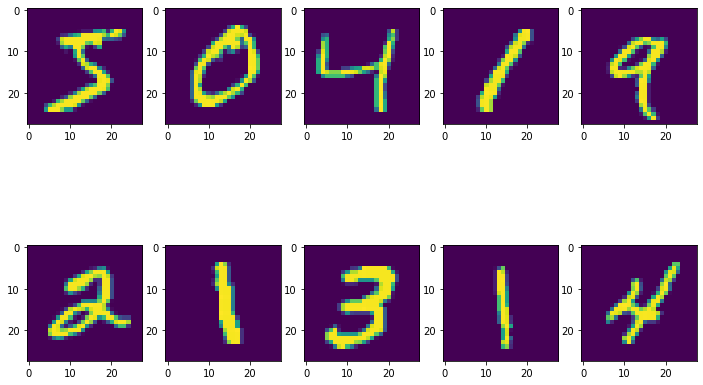

In [4]:
## show some images
plt.figure(figsize = (12, 8))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = dataloaders['train'].dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())

In [5]:
def train_model(model, optimizer, num_epochs=1, verbose = True, print_every = 100):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    loss_dict = {'train': [], 'val': []}
    
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for batch_idx, data in enumerate(dataloaders[phase]):
                # get the inputs
                inputs, labels = data

                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                
                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size()[0]
                running_corrects += torch.sum(preds == labels).item()
                
                if verbose and batch_idx % print_every == 0:
                    print('Train set | epoch: {:3d} | {:6d}/{:6d} batches | Loss: {:6.4f}'.format(
                        epoch, batch_idx * len(inputs), len(dataloaders[phase].dataset), loss.item()))
                    loss_dict[phase].append(running_loss/((batch_idx + 1) * len(inputs)))

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            loss_dict[phase].append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, loss_dict

def populate_result(dictionary, method, train_loss, val_loss):
    dictionary[method] = {}
    dictionary[method]['train_loss'] = np.array(train_loss)
    dictionary[method]['val_loss'] = np.array(val_loss)
    
def plot_loss(result, loss='train_loss', ylim=None):
    plt.plot(result['Baseline'][loss], label='Baseline')
    for k in result.keys():
        if k != 'Baseline':
            plt.plot(result[k][loss], label=k)
    if ylim is not None:
        plt.ylim(ylim)
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
def plot_best_loss(result, loss='val_loss'):
    labels = ['Baseline']
    acc = [np.max(result['Baseline'][loss])]
    for k in result.keys():
        if k != 'Baseline':
            labels.append(k)
            acc.append(np.max(result[k][loss]))

    x = np.arange(len(labels))
    plt.barh(x, acc)
    plt.yticks(x, labels)
    plt.xlabel('Loss')
    plt.show()

### Baseline method

We will later show how different optimization and regularization techniques can improve baseline model performance. But first,
1. What's our baseline model architecture?
2. What's the optimization method used to train the baseline model?
3. How does this optimization method update its parameters.
$$\theta_{t+1} = \theta_{t} - \eta \nabla J(\theta_{t})$$
where $\eta$ denotes the learning rate

In [6]:
class Baseline(nn.Module):
    def __init__(self, n_feature, output_size):
        super(Baseline, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Sequential(nn.Conv2d(1, n_feature, kernel_size=5),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2))
        self.conv2 = nn.Sequential(nn.Conv2d(n_feature, n_feature, kernel_size=5),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2))
        self.fc = nn.Sequential(nn.Linear(n_feature*4*4, 50),
                                nn.ReLU(),
                                nn.Linear(50, 10))


    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(-1, self.n_feature*4*4)
        x = self.fc(x)
        return x

In [7]:
torch.manual_seed(seed)
model = Baseline(n_feature, output_size).to(device)
optimizer = optim.SGD(model.parameters(),lr=0.01)
model, loss_dict = train_model(model, optimizer)
populate_result(optim_results, 'Baseline', loss_dict['train'], loss_dict['val'])

Epoch 0/0
----------
Train set | epoch:   0 |      0/ 60000 batches | Loss: 2.3144
Train set | epoch:   0 |   6400/ 60000 batches | Loss: 2.2539
Train set | epoch:   0 |  12800/ 60000 batches | Loss: 2.1788
Train set | epoch:   0 |  19200/ 60000 batches | Loss: 1.2514
Train set | epoch:   0 |  25600/ 60000 batches | Loss: 0.7360
Train set | epoch:   0 |  32000/ 60000 batches | Loss: 0.7064
Train set | epoch:   0 |  38400/ 60000 batches | Loss: 0.3541
Train set | epoch:   0 |  44800/ 60000 batches | Loss: 0.3663
Train set | epoch:   0 |  51200/ 60000 batches | Loss: 0.3876
Train set | epoch:   0 |  57600/ 60000 batches | Loss: 0.3185
train Loss: 1.0500 Acc: 0.6531
Train set | epoch:   0 |      0/ 10000 batches | Loss: 0.3797
val Loss: 0.3862 Acc: 0.8794

Training complete in 0m 21s
Best val Acc: 0.879400


## Fancier Optimization

https://pytorch.org/docs/stable/optim.html

### SGD with momentum
1. How does SGD with momentum update its parameters?
$$v_{t+1} = \rho v_{t} + \nabla J(\theta_{t})$$
$$\theta_{t+1} = \theta_{t} - \eta v_{t+1}$$
where $v$ and $\rho$ denote velocity and momentum, respectively.
2. Check out the documentation for SGD in PyTorch and complete the code below (Set momentum=0.5). 

In [8]:
torch.manual_seed(seed)
model = Baseline(n_feature, output_size).to(device)
optimizer = optim.SGD(model.parameters(),lr=0.01, momentum=0.5)
model, loss_dict = train_model(model, optimizer)
populate_result(optim_results, 'SGD_momentum', loss_dict['train'], loss_dict['val'])

Epoch 0/0
----------
Train set | epoch:   0 |      0/ 60000 batches | Loss: 2.3144
Train set | epoch:   0 |   6400/ 60000 batches | Loss: 2.1619
Train set | epoch:   0 |  12800/ 60000 batches | Loss: 0.8449
Train set | epoch:   0 |  19200/ 60000 batches | Loss: 0.6210
Train set | epoch:   0 |  25600/ 60000 batches | Loss: 0.5041
Train set | epoch:   0 |  32000/ 60000 batches | Loss: 0.4715
Train set | epoch:   0 |  38400/ 60000 batches | Loss: 0.3443
Train set | epoch:   0 |  44800/ 60000 batches | Loss: 0.3168
Train set | epoch:   0 |  51200/ 60000 batches | Loss: 0.3207
Train set | epoch:   0 |  57600/ 60000 batches | Loss: 0.2334
train Loss: 0.7155 Acc: 0.7656
Train set | epoch:   0 |      0/ 10000 batches | Loss: 0.2813
val Loss: 0.2791 Acc: 0.9151

Training complete in 0m 23s
Best val Acc: 0.915100


### Nesterov momentum

Make a minor change in the above code to apply Nesterov momentum (Set momentum=0.5). 

In [9]:
torch.manual_seed(seed)
model = Baseline(n_feature, output_size).to(device)
optimizer = optim.SGD(model.parameters(),lr=0.01, momentum=0.5, nesterov=True)
model, loss_dict = train_model(model, optimizer)
populate_result(optim_results, 'Nesterov_momentum', loss_dict['train'], loss_dict['val'])

Epoch 0/0
----------
Train set | epoch:   0 |      0/ 60000 batches | Loss: 2.3144
Train set | epoch:   0 |   6400/ 60000 batches | Loss: 2.1562
Train set | epoch:   0 |  12800/ 60000 batches | Loss: 0.8439
Train set | epoch:   0 |  19200/ 60000 batches | Loss: 0.5238
Train set | epoch:   0 |  25600/ 60000 batches | Loss: 0.5212
Train set | epoch:   0 |  32000/ 60000 batches | Loss: 0.4893
Train set | epoch:   0 |  38400/ 60000 batches | Loss: 0.2968
Train set | epoch:   0 |  44800/ 60000 batches | Loss: 0.3276
Train set | epoch:   0 |  51200/ 60000 batches | Loss: 0.3108
Train set | epoch:   0 |  57600/ 60000 batches | Loss: 0.2227
train Loss: 0.7143 Acc: 0.7656
Train set | epoch:   0 |      0/ 10000 batches | Loss: 0.2921
val Loss: 0.2924 Acc: 0.9102

Training complete in 0m 22s
Best val Acc: 0.910200


### AdaGrad

1. What's the motivation of AdaGrad?
2. Check out the documentation of AdaGrad in PyTorch and complete the code below. 

In [10]:
torch.manual_seed(seed)
model = Baseline(n_feature, output_size).to(device)
optimizer = optim.Adagrad(model.parameters(),lr=0.01)
model, loss_dict = train_model(model, optimizer)
populate_result(optim_results, 'Adagrad', loss_dict['train'], loss_dict['val'])

Epoch 0/0
----------
Train set | epoch:   0 |      0/ 60000 batches | Loss: 2.3144
Train set | epoch:   0 |   6400/ 60000 batches | Loss: 0.5852
Train set | epoch:   0 |  12800/ 60000 batches | Loss: 0.5989
Train set | epoch:   0 |  19200/ 60000 batches | Loss: 0.4282
Train set | epoch:   0 |  25600/ 60000 batches | Loss: 0.4224
Train set | epoch:   0 |  32000/ 60000 batches | Loss: 0.4427
Train set | epoch:   0 |  38400/ 60000 batches | Loss: 0.2775
Train set | epoch:   0 |  44800/ 60000 batches | Loss: 0.2503
Train set | epoch:   0 |  51200/ 60000 batches | Loss: 0.3220
Train set | epoch:   0 |  57600/ 60000 batches | Loss: 0.2099
train Loss: 0.4049 Acc: 0.8745
Train set | epoch:   0 |      0/ 10000 batches | Loss: 0.2717
val Loss: 0.2751 Acc: 0.9177

Training complete in 0m 27s
Best val Acc: 0.917700


### RMSprop

In [11]:
torch.manual_seed(seed)
model = Baseline(n_feature, output_size).to(device)
optimizer = optim.RMSprop(model.parameters(),lr=0.01, alpha=0.9)
model, loss_dict = train_model(model, optimizer)
populate_result(optim_results, 'RMSprop', loss_dict['train'], loss_dict['val'])

Epoch 0/0
----------
Train set | epoch:   0 |      0/ 60000 batches | Loss: 2.3144
Train set | epoch:   0 |   6400/ 60000 batches | Loss: 0.3963
Train set | epoch:   0 |  12800/ 60000 batches | Loss: 0.4541
Train set | epoch:   0 |  19200/ 60000 batches | Loss: 0.1984
Train set | epoch:   0 |  25600/ 60000 batches | Loss: 0.2686
Train set | epoch:   0 |  32000/ 60000 batches | Loss: 0.3069
Train set | epoch:   0 |  38400/ 60000 batches | Loss: 0.2723
Train set | epoch:   0 |  44800/ 60000 batches | Loss: 0.2364
Train set | epoch:   0 |  51200/ 60000 batches | Loss: 0.1811
Train set | epoch:   0 |  57600/ 60000 batches | Loss: 0.0723
train Loss: 0.3047 Acc: 0.9026
Train set | epoch:   0 |      0/ 10000 batches | Loss: 0.2812
val Loss: 0.2722 Acc: 0.9117

Training complete in 0m 26s
Best val Acc: 0.911700


### Adam

In [12]:
torch.manual_seed(seed)
model = Baseline(n_feature, output_size).to(device)
optimizer = optim.Adam(model.parameters(),lr=0.01, betas=(0.9, 0.99))
model, loss_dict = train_model(model, optimizer)
populate_result(optim_results, 'Adam', loss_dict['train'], loss_dict['val'])

Epoch 0/0
----------
Train set | epoch:   0 |      0/ 60000 batches | Loss: 2.3144
Train set | epoch:   0 |   6400/ 60000 batches | Loss: 0.3502
Train set | epoch:   0 |  12800/ 60000 batches | Loss: 0.3460
Train set | epoch:   0 |  19200/ 60000 batches | Loss: 0.3038
Train set | epoch:   0 |  25600/ 60000 batches | Loss: 0.3415
Train set | epoch:   0 |  32000/ 60000 batches | Loss: 0.3381
Train set | epoch:   0 |  38400/ 60000 batches | Loss: 0.1988
Train set | epoch:   0 |  44800/ 60000 batches | Loss: 0.2249
Train set | epoch:   0 |  51200/ 60000 batches | Loss: 0.2168
Train set | epoch:   0 |  57600/ 60000 batches | Loss: 0.1004
train Loss: 0.2731 Acc: 0.9132
Train set | epoch:   0 |      0/ 10000 batches | Loss: 0.1281
val Loss: 0.1386 Acc: 0.9588

Training complete in 0m 24s
Best val Acc: 0.958800


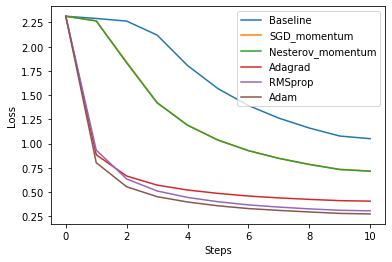

In [13]:
# Plot optimization methods training results
plot_loss(optim_results)

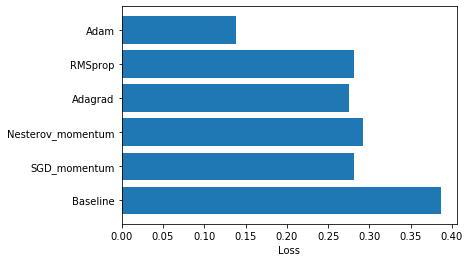

In [14]:
# Plot optimization methods validation results
plot_best_loss(optim_results)

## Regularization

https://pytorch.org/docs/stable/nn.html

In [15]:
# In order to see effects of regularization on validation set, we need to make some slight modification

## Smaller training set
mnist_datasets['train'].data = mnist_datasets['train'].data[:600]
dataset_sizes = {x: len(mnist_datasets[x]) for x in ['train', 'val']}
dataloaders['train'] = torch.utils.data.DataLoader(mnist_datasets['train'], 
                                                   batch_size=batch_size['train'], shuffle=True)

## Longer training epochs
train_epochs = 25
verbose = False
reg_results = {}

### Baseline model

In [16]:
torch.manual_seed(seed)
model = Baseline(n_feature, output_size).to(device)
optimizer = optim.Adam(model.parameters(),lr=0.01)
model, loss_dict = train_model(model, optimizer, num_epochs=train_epochs, verbose=verbose)
populate_result(optim_results, 'Baseline', loss_dict['train'], loss_dict['val'])

Epoch 0/24
----------
train Loss: 2.1326 Acc: 0.2250
val Loss: 1.5130 Acc: 0.5374

Epoch 1/24
----------
train Loss: 1.0338 Acc: 0.6717
val Loss: 0.9995 Acc: 0.6885

Epoch 2/24
----------
train Loss: 0.6660 Acc: 0.7783
val Loss: 0.8467 Acc: 0.7218

Epoch 3/24
----------
train Loss: 0.5707 Acc: 0.8150
val Loss: 0.6909 Acc: 0.7854

Epoch 4/24
----------
train Loss: 0.3902 Acc: 0.8883
val Loss: 0.7512 Acc: 0.7842

Epoch 5/24
----------
train Loss: 0.3514 Acc: 0.8983
val Loss: 0.5804 Acc: 0.8214

Epoch 6/24
----------
train Loss: 0.2554 Acc: 0.9167
val Loss: 0.5552 Acc: 0.8374

Epoch 7/24
----------
train Loss: 0.2056 Acc: 0.9367
val Loss: 0.6224 Acc: 0.8225

Epoch 8/24
----------
train Loss: 0.1891 Acc: 0.9417
val Loss: 0.6162 Acc: 0.8337

Epoch 9/24
----------
train Loss: 0.1437 Acc: 0.9450
val Loss: 0.5799 Acc: 0.8483

Epoch 10/24
----------
train Loss: 0.1251 Acc: 0.9617
val Loss: 0.6354 Acc: 0.8422

Epoch 11/24
----------
train Loss: 0.0996 Acc: 0.9667
val Loss: 0.6203 Acc: 0.8483

Ep

### L1/L2 regularization

L2 regularization is included in most optimizers in PyTorch and can be controlled with the __weight_decay__ parameter.
For L1 regularization, check out this post: https://discuss.pytorch.org/t/simple-l2-regularization/139

### Adding Dropout Layer

1. How does Dropout introduce regularization effect?
2. Check out documentations for __nn.Dropout()__. Modify the Baseline model and add dropout layer to the fully connected layers.
3. Optionally, you may also check out documentations for __nn.Dropout2d()__ to learn how to add Dropout layer to convolution layers.

In [17]:
class DropoutNet(nn.Module):
    def __init__(self, input_size, n_feature, output_size, dropout_rate=0.5):
        super(DropoutNet, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Sequential(nn.Conv2d(1, n_feature, kernel_size=5),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2))
        
        self.conv2 = nn.Sequential(nn.Conv2d(n_feature, n_feature, kernel_size=5),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2))
        self.fc = nn.Sequential(nn.Linear(n_feature*4*4, 50),
                                nn.ReLU(),
                                nn.Dropout(dropout_rate),
                                nn.Linear(50, 10))


    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(-1, self.n_feature*4*4)
        x = self.fc(x)
        return x

In [18]:
torch.manual_seed(seed)
model = DropoutNet(input_size, n_feature, output_size, dropout_rate=0.3).to(device)
optimizer = optim.Adam(model.parameters(),lr=0.01)
model, loss_dict = train_model(model, optimizer, num_epochs=train_epochs, verbose=verbose)
populate_result(optim_results, 'Dropout', loss_dict['train'], loss_dict['val'])

Epoch 0/24
----------
train Loss: 2.1951 Acc: 0.2067
val Loss: 1.6469 Acc: 0.4185

Epoch 1/24
----------
train Loss: 1.2526 Acc: 0.5983
val Loss: 0.9650 Acc: 0.6875

Epoch 2/24
----------
train Loss: 0.8219 Acc: 0.7367
val Loss: 0.7447 Acc: 0.7606

Epoch 3/24
----------
train Loss: 0.6347 Acc: 0.7900
val Loss: 0.6085 Acc: 0.7989

Epoch 4/24
----------
train Loss: 0.4685 Acc: 0.8333
val Loss: 0.4753 Acc: 0.8484

Epoch 5/24
----------
train Loss: 0.3789 Acc: 0.8650
val Loss: 0.4987 Acc: 0.8413

Epoch 6/24
----------
train Loss: 0.3355 Acc: 0.8750
val Loss: 0.5000 Acc: 0.8470

Epoch 7/24
----------
train Loss: 0.3070 Acc: 0.8867
val Loss: 0.5275 Acc: 0.8550

Epoch 8/24
----------
train Loss: 0.3057 Acc: 0.9133
val Loss: 0.4811 Acc: 0.8555

Epoch 9/24
----------
train Loss: 0.2582 Acc: 0.9267
val Loss: 0.4842 Acc: 0.8604

Epoch 10/24
----------
train Loss: 0.2243 Acc: 0.9150
val Loss: 0.4617 Acc: 0.8687

Epoch 11/24
----------
train Loss: 0.1819 Acc: 0.9350
val Loss: 0.4969 Acc: 0.8687

Ep

### Adding Batch Normalization
1. What's the advantage of using batch normalization?
    1. Allow each layer to train relatively more independently
    2. Improve gradient flow through the network
    3. Allows higher learning rate
    4. Reduces strong dependence on initialization
2. Batch normalization also act as a form of regularization, why?
3. Implement batch normalization in __BatchnormNet__. Think about where you may want to insert the batch normalization layer.

In [19]:
class BatchnormNet(nn.Module):
    def __init__(self, n_feature, output_size):
        super(BatchnormNet, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Sequential(nn.Conv2d(1, n_feature, kernel_size=5),
                                   nn.BatchNorm2d(n_feature),
                                   nn.MaxPool2d(2),
                                   nn.ReLU())
        
        self.conv2 = nn.Sequential(nn.Conv2d(n_feature, n_feature, kernel_size=5),
                                   nn.BatchNorm2d(n_feature),
                                   nn.MaxPool2d(2),
                                   nn.ReLU())
        self.fc = nn.Sequential(nn.Linear(n_feature*4*4, 50),
                                nn.BatchNorm1d(50),
                                nn.ReLU(),
                                nn.Linear(50, 10))


    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(-1, self.n_feature*4*4)
        x = self.fc(x)
        return x

In [20]:
torch.manual_seed(seed)
model = BatchnormNet(n_feature, output_size).to(device)
optimizer = optim.Adam(model.parameters(),lr=0.01)
model, loss_dict = train_model(model, optimizer, num_epochs=train_epochs, verbose=verbose)
populate_result(optim_results, 'Batchnorm', loss_dict['train'], loss_dict['val'])

Epoch 0/24
----------
train Loss: 1.6842 Acc: 0.4850
val Loss: 1.3643 Acc: 0.6680

Epoch 1/24
----------
train Loss: 0.7893 Acc: 0.8400
val Loss: 0.7917 Acc: 0.7655

Epoch 2/24
----------
train Loss: 0.4234 Acc: 0.9017
val Loss: 0.5911 Acc: 0.8081

Epoch 3/24
----------
train Loss: 0.2524 Acc: 0.9433
val Loss: 0.4821 Acc: 0.8477

Epoch 4/24
----------
train Loss: 0.1552 Acc: 0.9650
val Loss: 0.5476 Acc: 0.8219

Epoch 5/24
----------
train Loss: 0.0960 Acc: 0.9833
val Loss: 0.4578 Acc: 0.8577

Epoch 6/24
----------
train Loss: 0.0650 Acc: 0.9933
val Loss: 0.3228 Acc: 0.8998

Epoch 7/24
----------
train Loss: 0.0532 Acc: 0.9900
val Loss: 0.3617 Acc: 0.8870

Epoch 8/24
----------
train Loss: 0.0396 Acc: 0.9950
val Loss: 0.3302 Acc: 0.8972

Epoch 9/24
----------
train Loss: 0.0295 Acc: 1.0000
val Loss: 0.3796 Acc: 0.8832

Epoch 10/24
----------
train Loss: 0.0278 Acc: 0.9967
val Loss: 0.3614 Acc: 0.8897

Epoch 11/24
----------
train Loss: 0.0243 Acc: 0.9983
val Loss: 0.3520 Acc: 0.8907

Ep

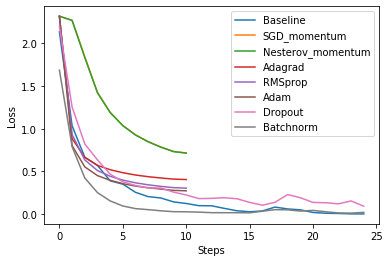

In [23]:
plot_loss(optim_results)

Validation loss using Dropout and Batchnorm start to catch up with the loss of baseline model after baseline model overfits training data.

In [22]:
reg_results

{}

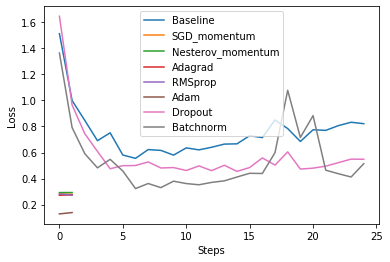

In [26]:
plot_loss(optim_results, loss = 'val_loss')

## Exercise: parameter tunning

We've introduced multiple regularization and optimization techniques to improve your model. How can you combine these techniques and perform grid search to find out a set of parameters that maximize your model performance on validation set? Are there other model architectures you'd like to try?